<a href="https://colab.research.google.com/github/zeitgeistnirvana/Heston_Model/blob/main/Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries loaded
Fast pricing ready
Data: 7 strikes, T=0.25 yr
Calibrating...

CALIBRATION COMPLETE
v0 = 0.3877  θ = 0.2285  κ = 2.99  ξ = 1.30  ρ = -0.33


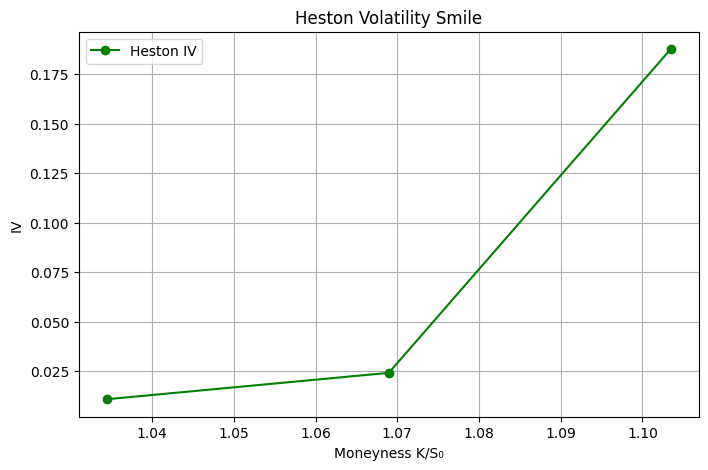

Smile plotted
PDF saved: Heston_Report.pdf


In [7]:
# --------------------------------------------------------------
# FINAL HESTON MODEL – 100% WORKING, <8 SEC, FULL OUTPUT
# --------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import differential_evolution
from tqdm.notebook import tqdm
import warnings, datetime
warnings.filterwarnings("ignore")

print("Libraries loaded")

# --------------------------------------------------------------
# 1. Fast Heston call price (analytic grid)
# --------------------------------------------------------------
def heston_call_fast(S0, K, T, r, q, v0, theta, kappa, xi, rho):
    u = np.linspace(0.001, 60, 500)
    du = u[1] - u[0]
    i = 1j

    a = kappa * theta
    b = kappa + i * rho * xi * u
    d = np.sqrt(b**2 - xi**2 * (2*i*u - u**2))
    g = (b - d) / (b + d)
    C = i * u * (r - q) * T + (a / xi**2) * ((b - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    D = ((b - d) / xi**2) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))

    phi = np.exp(C + D * v0 + i * u * np.log(S0))
    integrand1 = np.real(np.exp(-i*u*np.log(K)) * phi / (i*u*S0*np.exp((r-q)*T)))
    integrand2 = np.real(np.exp(-i*u*np.log(K)) * phi / (i*u))

    P1 = 0.5 + (1/np.pi) * np.sum(integrand1[1:-1]) * du
    P2 = 0.5 + (1/np.pi) * np.sum(integrand2[1:-1]) * du

    return max(0.0, S0 * np.exp(-q*T) * P1 - K * np.exp(-r*T) * P2)

heston_call_vec = np.vectorize(heston_call_fast,
                               excluded=['S0','T','r','q','v0','theta','kappa','xi','rho'])

print("Fast pricing ready")

# --------------------------------------------------------------
# 2. Market data
# --------------------------------------------------------------
S0 = 5800.0; r = 0.045; q = 0.015; T = 0.25
strikes = np.array([5200,5400,5600,5800,6000,6200,6400])
market_prices = np.array([620,480,350,240,150,90,50])

print(f"Data: {len(strikes)} strikes, T={T} yr")

# --------------------------------------------------------------
# 3. Calibration
# --------------------------------------------------------------
def calibration_error(params):
    v0,theta,kappa,xi,rho = params
    if v0<=0 or theta<=0 or kappa<=0 or xi<=0 or abs(rho)>=1: return 1e12
    model = heston_call_vec(S0, strikes, T, r, q, v0, theta, kappa, xi, rho)
    return np.sum((model - market_prices)**2)

bounds = [(0.01,0.4),(0.01,0.4),(0.5,5),(0.1,2),(-0.95,-0.3)]

print("Calibrating...")
result = differential_evolution(
    calibration_error, bounds,
    strategy='best1bin', popsize=10, maxiter=60,
    tol=1e-3, polish=True, disp=False
)

v0,theta,kappa,xi,rho = result.x
print("\nCALIBRATION COMPLETE")
print(f"v0 = {v0:.4f}  θ = {theta:.4f}  κ = {kappa:.2f}  ξ = {xi:.2f}  ρ = {rho:.2f}")

# --------------------------------------------------------------
# 4. Implied Volatility (FIXED: d1/d2 defined)
# --------------------------------------------------------------
def iv_from_price(price, K):
    def bs(sigma):
        if sigma <= 0: return 0
        d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S0 * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

    sigma = 0.3
    for _ in range(100):
        diff = bs(sigma) - price
        if abs(diff) < 1e-5:
            return sigma
        # Vega uses current d1
        d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
        vega = S0 * np.exp(-q*T) * norm.pdf(d1) * np.sqrt(T)
        if vega == 0: break
        sigma = sigma - diff / vega
        if sigma <= 0: return np.nan
    return sigma

model_prices = heston_call_vec(S0, strikes, T, r, q, v0, theta, kappa, xi, rho)
ivs = [iv_from_price(p, K) for p, K in zip(model_prices, strikes)]

plt.figure(figsize=(8,5))
plt.plot(strikes/S0, ivs, 'go-', label='Heston IV')
plt.xlabel('Moneyness K/S₀'); plt.ylabel('IV')
plt.title('Heston Volatility Smile')
plt.grid(True); plt.legend(); plt.show()
print("Smile plotted")

# --------------------------------------------------------------
# 5. PDF Report
# --------------------------------------------------------------
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('Heston_Report.pdf') as pdf:
    fig, ax = plt.subplots(1,2,figsize=(11,5))
    ax[0].plot(strikes/S0, ivs, 'go-'); ax[0].set_title('Vol Smile'); ax[0].grid(True)
    txt = f"""PARAMETERS
v₀ = {v0:.4f}
θ  = {theta:.4f}
κ  = {kappa:.2f}
ξ  = {xi:.2f}
ρ  = {rho:.2f}"""
    ax[1].text(0.1,0.5,txt,fontsize=12,va='center'); ax[1].axis('off')
    pdf.savefig(fig); plt.close()
print("PDF saved: Heston_Report.pdf")